In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet

In [12]:
df = pd.read_csv('DHS_weekly.csv')
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          366 non-null    object 
 1   Total Individuals in Shelter  366 non-null    int64  
 2   Easter                        366 non-null    int64  
 3   Thanksgiving                  366 non-null    int64  
 4   Christmas                     366 non-null    int64  
 5   Temperature                   366 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 17.3+ KB


In [14]:
df.describe()

,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,405042.808743,0.019126,0.019126,0.019126,14.842424
std,19375.509125,0.137154,0.137154,0.137154,8.511113
min,212514.000000,0.000000,0.000000,0.000000,-4.318571
25%,397040.250000,0.000000,0.000000,0.000000,7.503571
50%,408495.000000,0.000000,0.000000,0.000000,14.918571
75%,418908.750000,0.000000,0.000000,0.000000,22.792143
max,428607.000000,1.000000,1.000000,1.000000,28.535714


<Axes: >

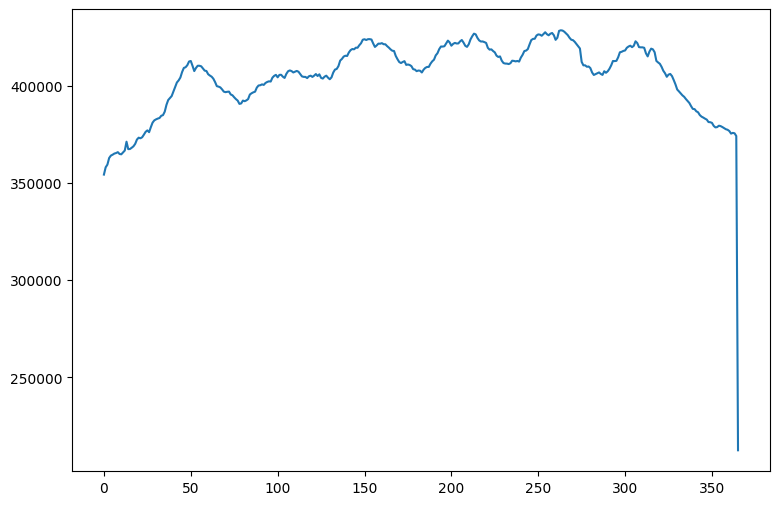

In [15]:
df['Total Individuals in Shelter'].plot(figsize=(9,6))

## Data Preparation

In [16]:
#date variable and rename date and y
df.Date = pd.to_datetime(df.Date,
                        format = "%m/%d/%Y")

df = df.rename(columns = {'Date':'ds',
                         'Total Individuals in Shelter': 'y'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848000
1,2014-01-12,358103,0,0,0,3.257143
2,2014-01-19,359491,0,0,0,5.632857
3,2014-01-26,362880,0,0,0,-1.850000
4,2014-02-02,364125,0,0,0,1.177143


## Holidays

In [18]:
#Easter Holiday
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                      'ds': easter_dates,
                      'lower_window': -7, #A week before
                      'upper_window': 7}) #after a week

In [20]:
#Thanksgiving
tgiving_dates = df[df.Thanksgiving == 1].ds
tgiving = pd.DataFrame({'holiday': 'thanksgiving',
                      'ds': tgiving_dates,
                      'lower_window': -7, # A week before
                      'upper_window': 7}) #after a week

In [21]:
#Combine Holidays
holidays = pd.concat([tgiving, easter])
holidays

,holiday,ds,lower_window,upper_window
47,thanksgiving,2014-11-30,-7,7
99,thanksgiving,2015-11-29,-7,7
151,thanksgiving,2016-11-27,-7,7
203,thanksgiving,2017-11-26,-7,7
255,thanksgiving,2018-11-25,-7,7
308,thanksgiving,2019-12-01,-7,7
360,thanksgiving,2020-11-29,-7,7
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7


In [22]:
#Remove holidays from the main df
df = df.drop(columns = ['Thanksgiving', 'Easter'])
df.head()

,ds,y,Christmas,Temperature
0,2014-01-05,354354,0,0.848000
1,2014-01-12,358103,0,3.257143
2,2014-01-19,359491,0,5.632857
3,2014-01-26,362880,0,-1.850000
4,2014-02-02,364125,0,1.177143


## Prophet Model

In [25]:
#Training and test split
test_weeks = 4
training = df.iloc[:-4, :]
test = df.iloc[-4:, :]
test

,ds,y,Christmas,Temperature
362,2020-12-13,375820,0,8.208571
363,2020-12-20,375615,0,3.535714
364,2020-12-27,374203,1,7.510000
365,2021-01-03,212514,0,6.625000


In [26]:
#prophet model
m = Prophet(growth = 'linear',
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = 'multiplicative',
           seasonality_prior_scale = 10,
           holidays_prior_scale = 10,
           changepoint_prior_scale = 0.05)

m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

13:36:18 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
#Regressor Coefficients
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.001413,-0.001413,-0.001413
1,Temperature,multiplicative,14.934939,-0.001968,-0.001968,-0.001968


## Forecasting

In [29]:
#Create future dataframe
future = m.make_future_dataframe(periods = test_weeks,
                                freq = 'W')

future = pd.concat([future, df.iloc[:, 2:]],
                  axis = 1)

future

,ds,Christmas,Temperature
0,2014-01-05,0,0.848000
1,2014-01-12,0,3.257143
2,2014-01-19,0,5.632857
3,2014-01-26,0,-1.850000
4,2014-02-02,0,1.177143
...,...,...,...
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000


In [33]:
#Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-05,57848.658183,352940.751496,358082.643975,57848.658183,57848.658183,0.0,0.0,0.0,0.027722,...,5.049694,5.049694,5.049694,0.069128,0.069128,0.069128,0.0,0.0,0.0,355569.313241
1,2014-01-12,58032.074672,354797.090605,360131.032250,58032.074672,58032.074672,0.0,0.0,0.0,0.022981,...,5.049694,5.049694,5.049694,0.086314,0.086314,0.086314,0.0,0.0,0.0,357418.921386
2,2014-01-19,58215.491160,356942.643081,362220.699012,58215.491160,58215.491160,0.0,0.0,0.0,0.018306,...,5.049694,5.049694,5.049694,0.110196,0.110196,0.110196,0.0,0.0,0.0,359666.703903
3,2014-01-26,58398.907649,359761.204632,365274.680677,58398.907649,58398.907649,0.0,0.0,0.0,0.033031,...,5.049694,5.049694,5.049694,0.125376,0.125376,0.125376,0.0,0.0,0.0,362546.315374
4,2014-02-02,58582.324138,360696.000168,366176.913392,58582.324138,58582.324138,0.0,0.0,0.0,0.027074,...,5.049694,5.049694,5.049694,0.125273,0.125273,0.125273,0.0,0.0,0.0,363329.997258


In [34]:
#Holiday assessment
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,thanksgiving
359,2020-11-22,0.008264
360,2020-11-29,-0.010969
361,2020-12-06,-0.027241


In [35]:
holiday = 'easter'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,easter
326,2020-04-05,-0.014218
327,2020-04-12,-0.018101
328,2020-04-19,-0.015692


In [36]:
holiday = 'Christmas'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,Christmas
364,2020-12-27,-0.001413


In [38]:
#retrieve the predictions
predictions = forecast.yhat[-test_weeks:]
predictions

362    385100.656686
363    384561.092051
364    382455.533864
365    381731.585771
Name: yhat, dtype: float64

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

48924.21709257091
84954.19177517151


## Visualization

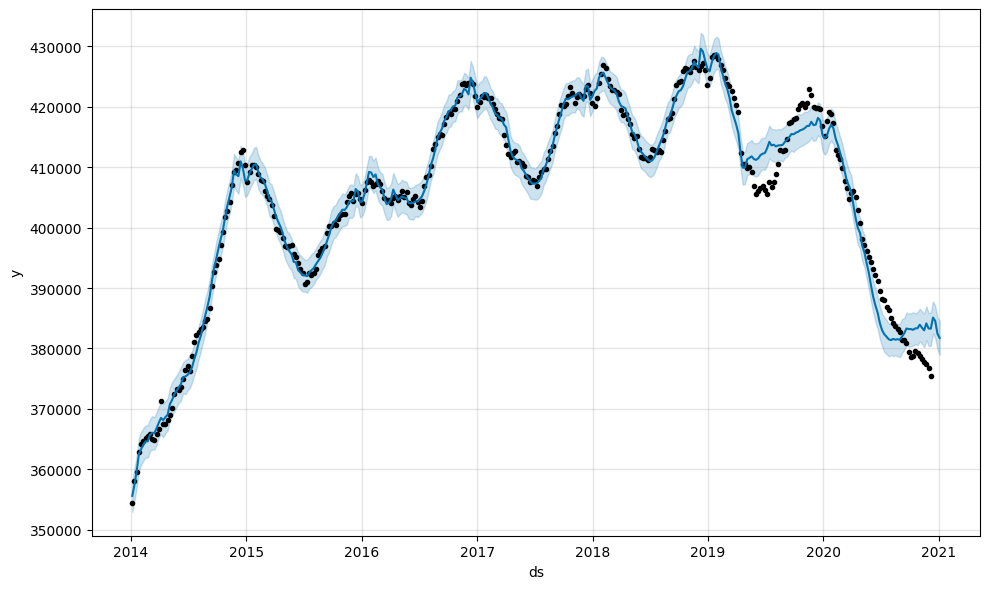

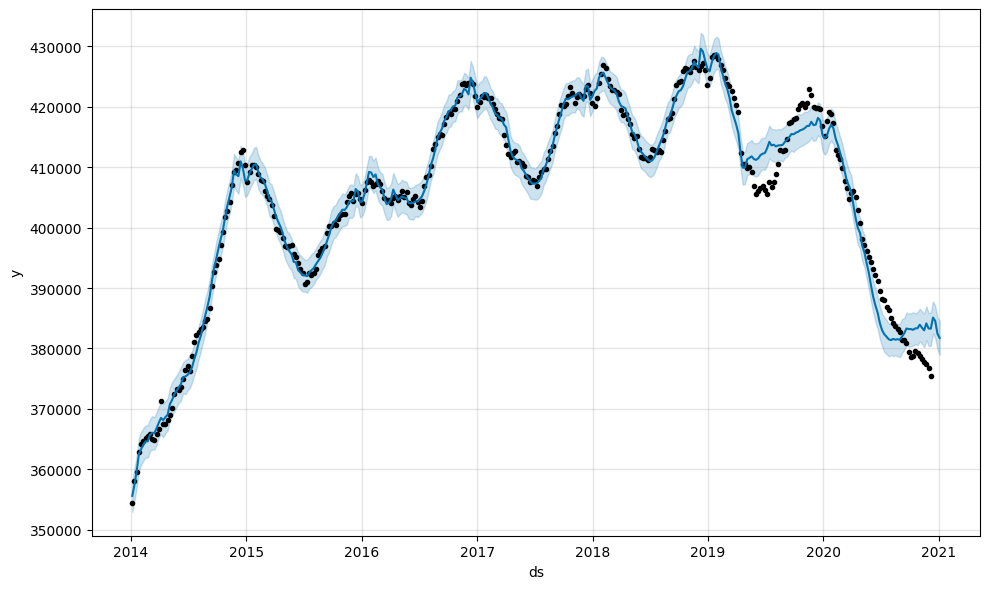

In [40]:
m.plot(forecast)

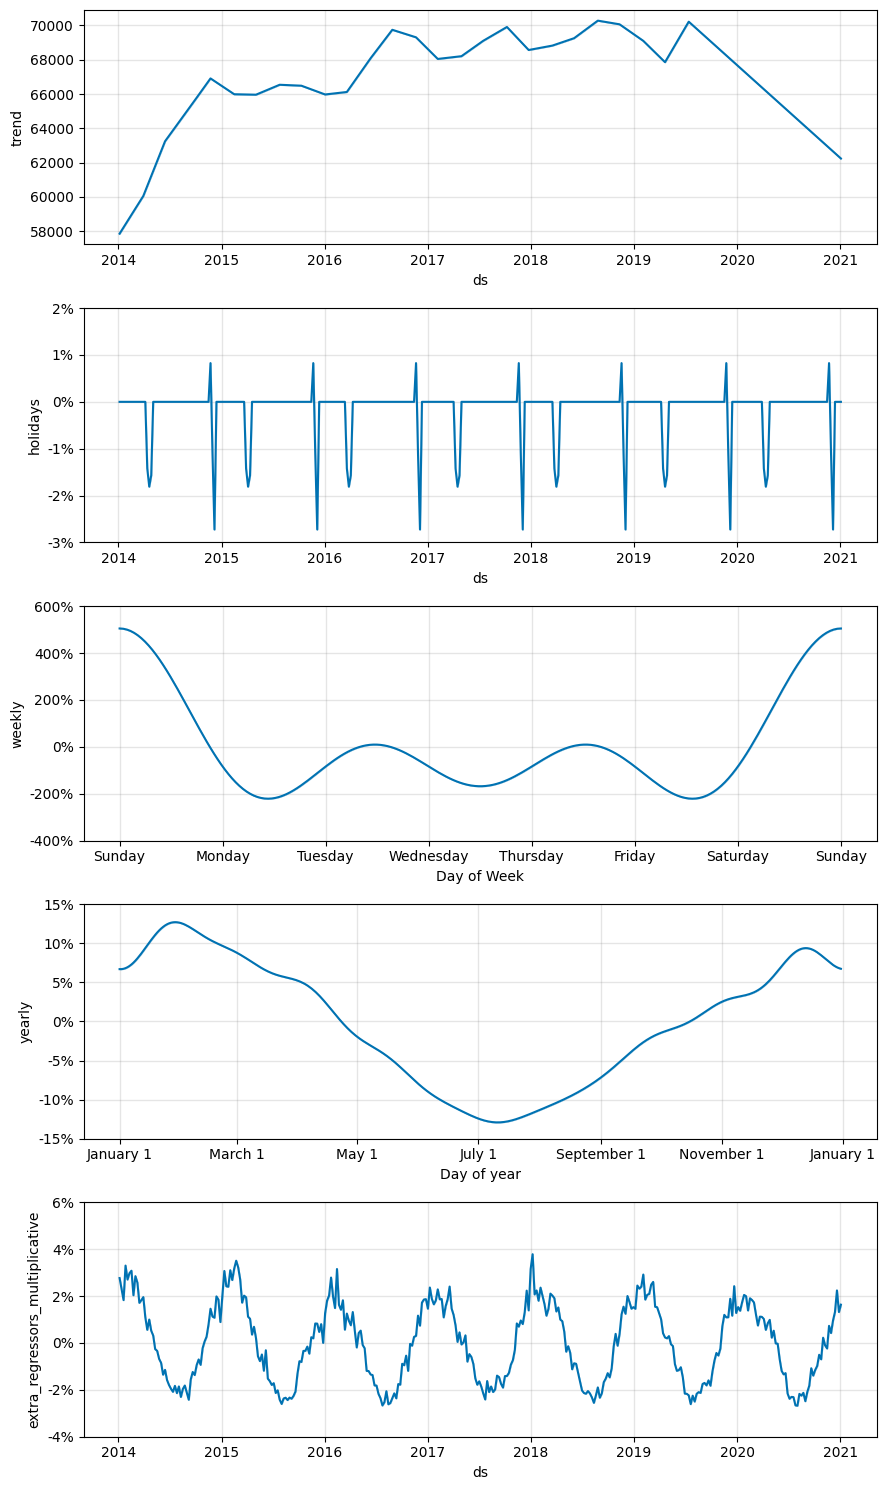

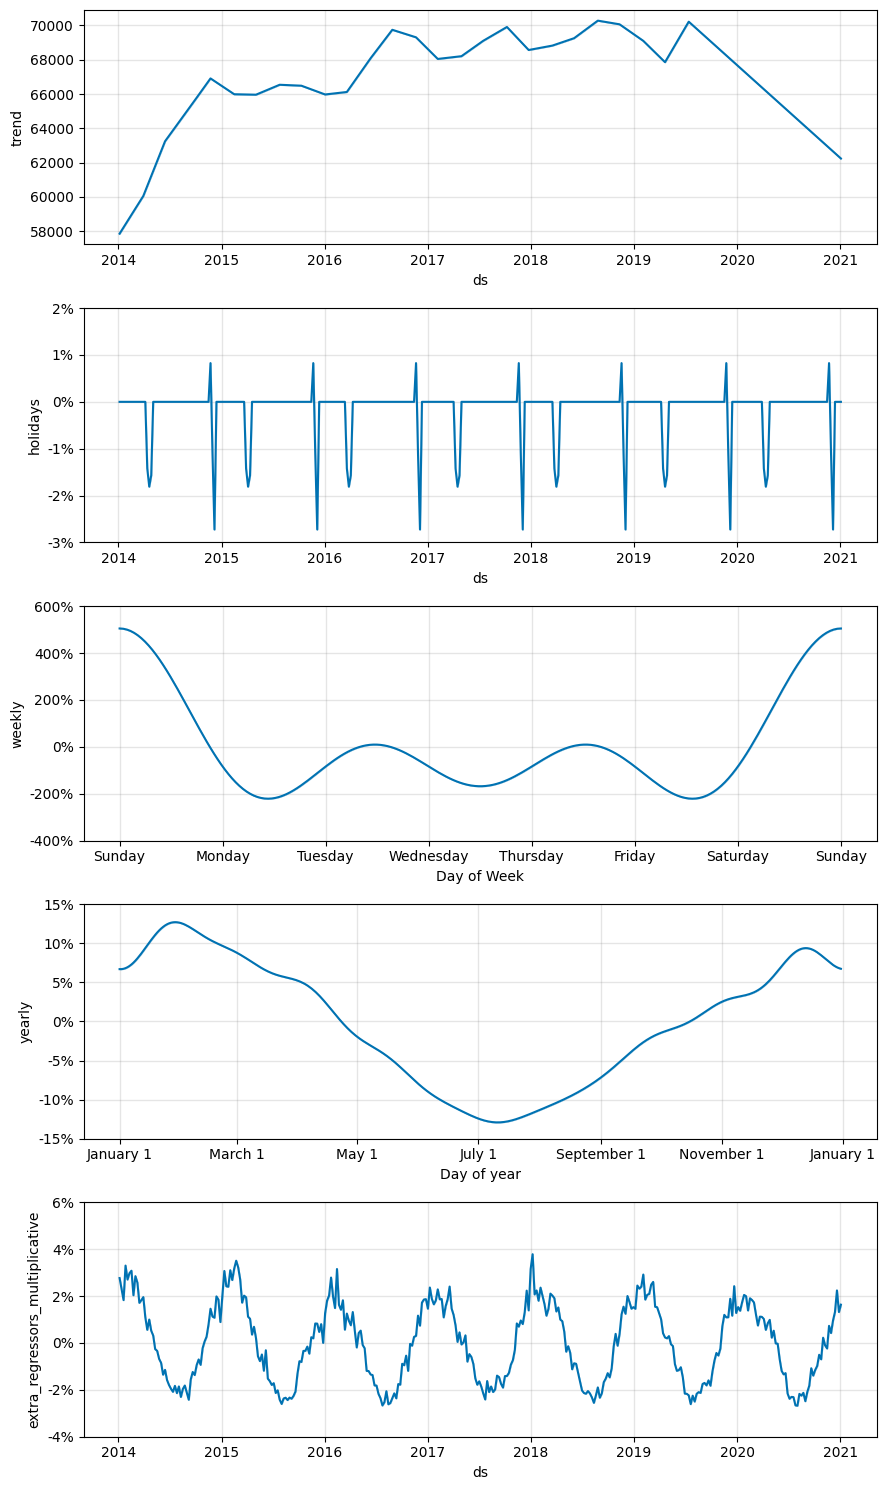

In [41]:
#plot components -> structural time series decomposition
m.plot_components(forecast)

## Cross Validation

In [45]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                        horizon = '4 W',
                        initial = '300 W',
                        parallel = 'processes')

In [46]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,420051.269254,418923.872925,421151.578834,420265,2019-10-13
1,2019-10-27,420735.646350,419558.511885,421887.609210,420670,2019-10-13
2,2019-11-03,421253.616887,419985.773540,422623.097299,419924,2019-10-13
3,2019-11-10,421397.261687,420108.243396,422770.309992,420624,2019-10-13
4,2019-11-03,421375.000589,420224.822266,422546.917552,419924,2019-10-27


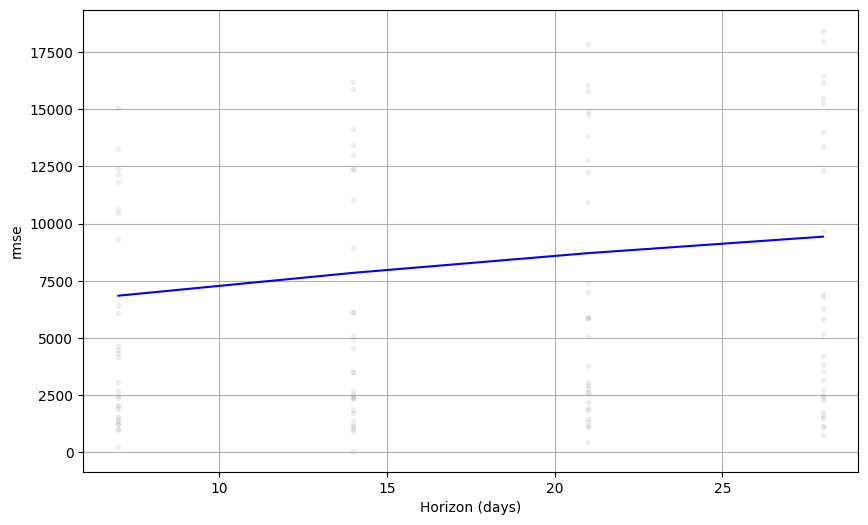

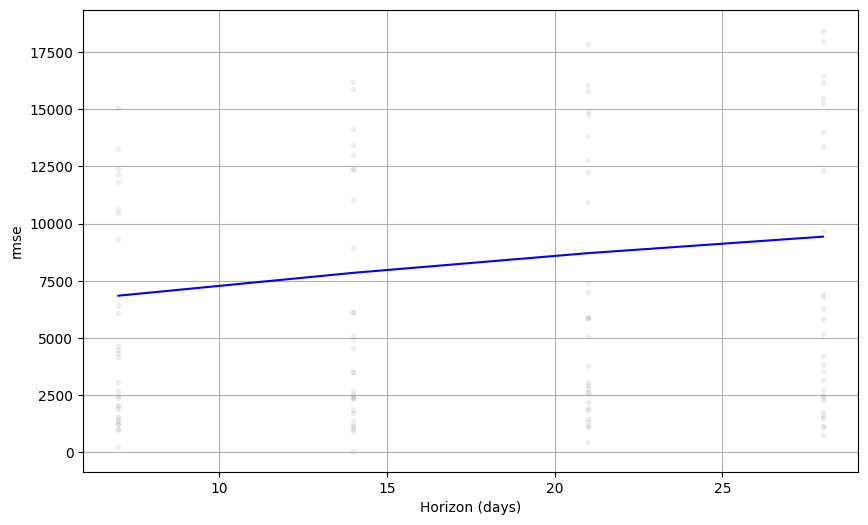

In [47]:
#CV Visualisation
from prophet.plot import plot_cross_validation_metric as pc

pc(df_cv, metric='rmse')

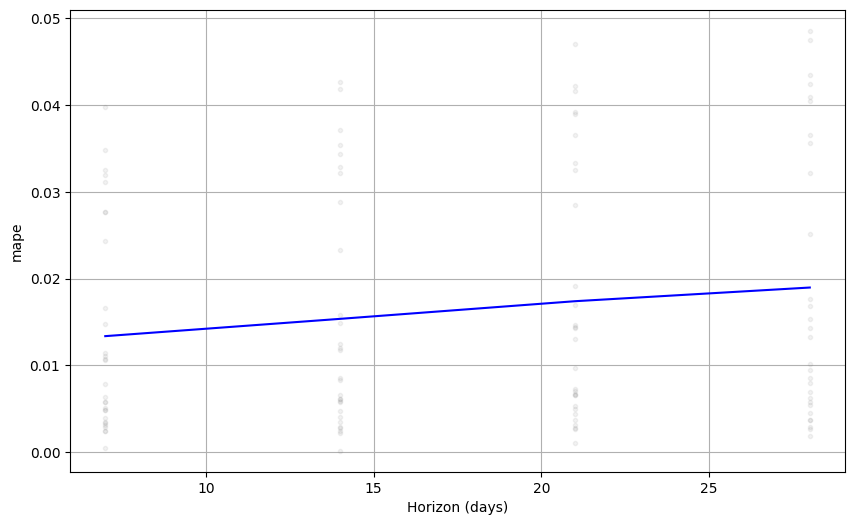

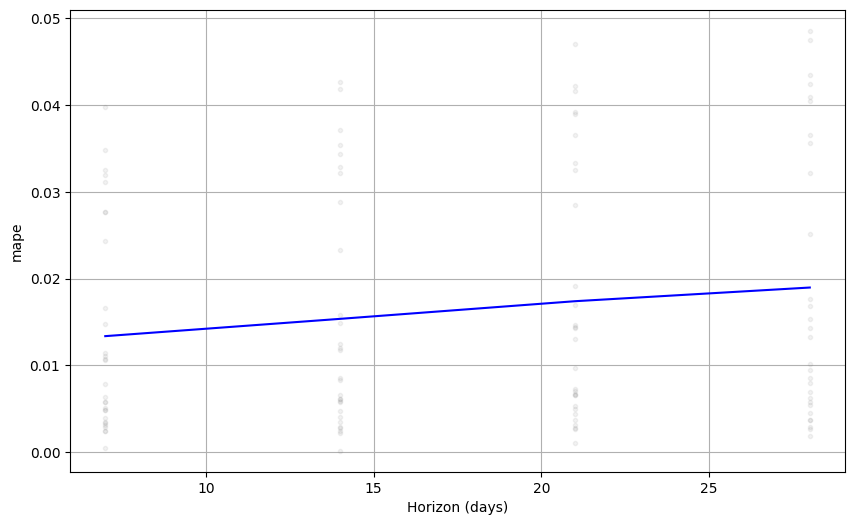

In [48]:
pc(df_cv, metric='mape')

## Parameter Tuning

In [52]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
             'seasonality_prior_scale': [5, 10, 20],
             'holidays_prior_scale': [5, 10, 20],
             'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))
print(grid)

In [53]:
#Empty list to store the results

rmse = []

for i in grid:
    
    #Build the Model
    m = Prophet(growth = 'linear',
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = 'multiplicative',
           seasonality_prior_scale = 10,
           holidays_prior_scale = 10,
           changepoint_prior_scale = 0.05)

    m.add_regressor('Christmas')
    m.add_regressor('Temperature')
    m.fit(training)
    
    #Cross-Validation
    df_cv = cross_validation(m,
                        horizon = '4 W',
                        initial = '300 W',
                        parallel = 'processes')
    
    #Measure and append to the list
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmse.append(error)

13:56:27 - cmdstanpy - INFO - Chain [1] start processing
13:56:27 - cmdstanpy - INFO - Chain [1] done processing
13:56:33 - cmdstanpy - INFO - Chain [1] start processing
13:56:33 - cmdstanpy - INFO - Chain [1] done processing
13:56:38 - cmdstanpy - INFO - Chain [1] start processing
13:56:39 - cmdstanpy - INFO - Chain [1] done processing
13:56:44 - cmdstanpy - INFO - Chain [1] start processing
13:56:44 - cmdstanpy - INFO - Chain [1] done processing
13:56:49 - cmdstanpy - INFO - Chain [1] start processing
13:56:50 - cmdstanpy - INFO - Chain [1] done processing
13:56:55 - cmdstanpy - INFO - Chain [1] start processing
13:56:55 - cmdstanpy - INFO - Chain [1] done processing
13:57:00 - cmdstanpy - INFO - Chain [1] start processing
13:57:01 - cmdstanpy - INFO - Chain [1] done processing
13:57:06 - cmdstanpy - INFO - Chain [1] start processing
13:57:06 - cmdstanpy - INFO - Chain [1] done processing
13:57:11 - cmdstanpy - INFO - Chain [1] start processing
13:57:12 - cmdstanpy - INFO - Chain [1]

In [54]:
#Tuning Results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results